In [88]:
import warnings
warnings.filterwarnings("ignore")

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from math import cos, sin, radians
from sklearn.preprocessing import OneHotEncoder

# LR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

# K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [90]:
# Load dataset

initial_dataset = pd.read_csv('House_Price_Prediction.csv')
initial_dataset.shape

(29451, 12)

In [91]:
initial_dataset.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


## Preprocessing

1. Removes irrelevant fields
2. Handles categorial variables
3. Converts latitude-longitude to xyz coordinates (for further clustering in next step)

In [92]:
# Remove unnecessary and overwritten columns

def cleanDF(data):
    clean_df = data.drop(['POSTED_BY', 'RERA', 'BHK_OR_RK', 'ADDRESS', 'LONGITUDE', 'LATITUDE'], axis=1, errors='ignore')
    return clean_df

In [93]:
# Handle categorical variables using OneHotEncoder
# : Generates new boolean fields based off possible categories of categorial variables

def handleCategoricalVariables(data):
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded_data = encoder.fit_transform(data[['POSTED_BY', 'BHK_OR_RK']])
    column_names = encoder.get_feature_names_out(['POSTED_BY', 'BHK_OR_RK'])
    encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=column_names)
    return encoded_df

In [94]:
# Converts latitute and longitude to 3D coordinates (x,y,z)

def get3DCoordinatesFromLatLong(lat, long):
    # Degrees to radians
    lat = radians(lat)
    long = radians(long)

    r = 10000
    x = r * cos(lat) * cos(long)
    y = r * cos(lat) * sin(long)
    z = r * sin(lat)

    return (x, y, z)

In [95]:
# Preprocess dataset

def preprocessDF(data):
    cl_df = cleanDF(data)
    cl_df.rename(columns={'TARGET(PRICE_IN_LACS)': 'PRICE_IN_LACS'}, inplace=True)
    
    x = []
    y = []
    z = []
    for i in range(data.shape[0]):
        xyz = get3DCoordinatesFromLatLong(data.iloc[i,:]['LATITUDE'], data.iloc[i,:]['LONGITUDE'])
        x.append(xyz[0])
        y.append(xyz[1])
        z.append(xyz[2])
    cl_df['X'] = x
    cl_df['Y'] = y
    cl_df['Z'] = z

    cv_df = handleCategoricalVariables(data)

    processed_df = pd.concat([cl_df, cv_df], axis=1)

    return processed_df

In [96]:
processed_dataset = preprocessDF(initial_dataset)
processed_dataset.head()

,UNDER_CONSTRUCTION,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,PRICE_IN_LACS,X,Y,Z,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,BHK_OR_RK_BHK,BHK_OR_RK_RK
0,0,2,1300.236407,1,1,55.0,2092.909009,482.028541,9766.646321,0.0,0.0,1.0,1.0,0.0
1,0,2,1275.000000,1,1,51.0,2257.101141,491.077006,9729.560001,0.0,1.0,0.0,1.0,0.0
2,0,2,933.159722,1,1,43.0,2088.820643,473.726296,9767.927708,0.0,0.0,1.0,1.0,0.0
3,0,2,929.921143,1,1,62.5,1922.784656,1050.178488,9757.049980,0.0,0.0,1.0,1.0,0.0
4,1,2,999.009247,0,1,60.5,244.112549,101.575258,9996.503965,0.0,1.0,0.0,1.0,0.0


In [97]:
X = processed_dataset
Y = processed_dataset['PRICE_IN_LACS']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

## Clustering
Clusters houses based off there xyz coordinates to seperate out localities 

In [99]:
X_train_xyz = X_train.loc[:,['X', 'Y', 'Z']]
X_train_xyz.head()

,X,Y,Z
15659,2091.629675,487.272028,9766.660190
4650,1926.158106,1049.399345,9756.468417
18961,535.563237,259.821327,9982.267523
17928,2193.908332,1111.233146,9692.880229
21817,2100.744755,481.995370,9764.965537


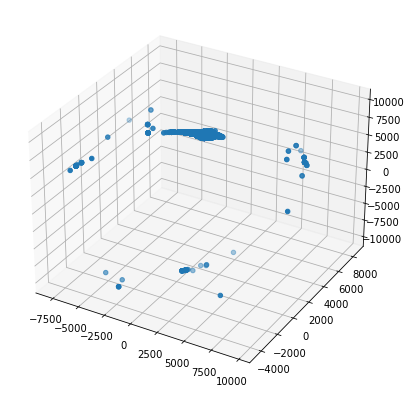

In [100]:
plt.figure(figsize=(10,7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_train_xyz['X'], X_train_xyz['Y'], X_train_xyz['Z'])
plt.show()

In [101]:
# Find optimal k for KMeans clustering using Davies Bouldin score and Elbow method

k_optimal = 1
db_min = 1000

inertia = {}
db = {}
for k in range(2,50):
    kmeans = KMeans(n_clusters=k, max_iter=10000, random_state=322)
    kmeans.fit(X_train_xyz)
    labels = kmeans.predict(X_train_xyz)

    inertia[k] = kmeans.inertia_
    db[k] = davies_bouldin_score(X_train_xyz, labels)
    
    if db[k] < db_min:
        db_min = db[k]
        k_optimal = k

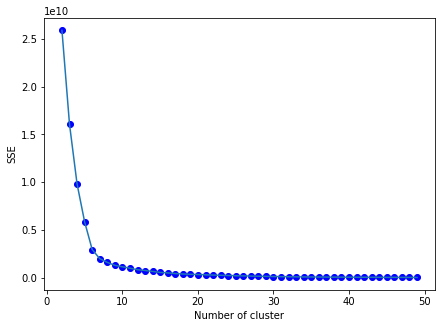

In [102]:
plt.figure(figsize=(7,5))
plt.plot(list(inertia.keys()), list(inertia.values()),'bo')
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

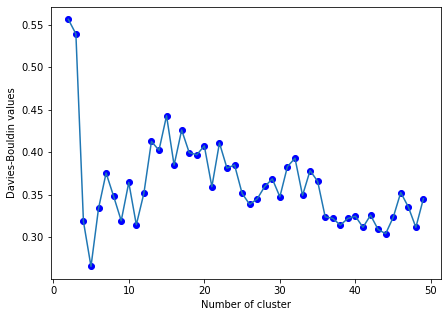

In [103]:
plt.figure(figsize=(7,5))
plt.plot(list(db.keys()), list(db.values()), 'bo')
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

In [104]:
# Clustering into k_optimal localities

kmeans = KMeans(n_clusters=k_optimal, max_iter=100000, random_state=322)
kmeans.fit(X_train_xyz)
labels = kmeans.predict(X_train_xyz)

# Adding LOCALITY_ID for each house in training dataset
X_train['LOCALITY_ID'] = labels

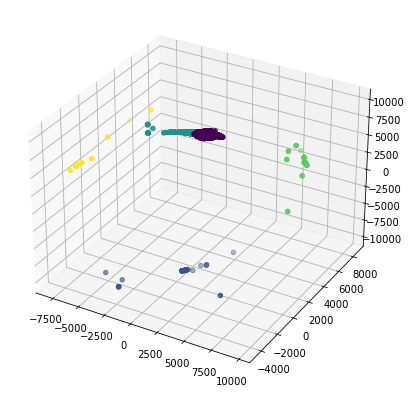

In [105]:
plt.figure(figsize=(10,7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_train_xyz['X'], X_train_xyz['Y'], X_train_xyz['Z'], c=labels)
plt.show()

In [106]:
# Seperating localities

localities = []
for locality_id in range(k_optimal):
    localities.append(X_train[X_train['LOCALITY_ID'] == locality_id])

## Linear Regression with Clustering
Train different linear regression models for every locality

In [107]:
locality_LR = []
locality_LR_r2_score = []

for locality in localities:
    x = locality.drop(['LOCALITY_ID', 'X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)
    y = locality['PRICE_IN_LACS']

    linear_reg = LinearRegression()
    linear_reg.fit(x, y)
    locality_LR.append(linear_reg)

    y_pred = linear_reg.predict(x)
    locality_LR_r2_score.append(r2_score(y, y_pred))

locality_LR_r2_score

[0.18993942741059255,
 0.2620066256818804,
 0.8952714397636302,
 0.6211834588916958,
 0.7709845143436518]

In [118]:
print(f"Train R2 Score: {locality_LR_r2_score}")

Train R2 Score: [0.18993942741059255, 0.2620066256818804, 0.8952714397636302, 0.6211834588916958, 0.7709845143436518]


### Prediction

In [108]:
X_test_df = X_test.drop(['X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)
price_predictions = {}

X_test_df

,UNDER_CONSTRUCTION,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,BHK_OR_RK_BHK,BHK_OR_RK_RK
28582,0,2,1090.116279,1,1,0.0,1.0,0.0,1.0,0.0
23148,1,2,858.152448,0,1,0.0,1.0,0.0,1.0,0.0
15168,0,2,1100.016923,1,1,0.0,1.0,0.0,1.0,0.0
6880,0,3,1395.117090,1,1,0.0,1.0,0.0,1.0,0.0
6351,0,3,1552.053486,1,1,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12368,0,2,889.756944,1,1,0.0,1.0,0.0,1.0,0.0
19598,0,6,5081.300813,1,1,0.0,1.0,0.0,1.0,0.0
21924,0,1,620.017715,1,1,0.0,1.0,0.0,1.0,0.0
14258,0,2,940.144155,1,1,0.0,0.0,1.0,1.0,0.0


In [109]:
# Predicting price of a house in each locality based off the linear regression models trained for localities

for locality_id, lr in enumerate(locality_LR):
    price_predictions[f'LOCALITY_{locality_id}_PRICE'] = lr.predict(X_test_df)

In [110]:
price_predictions_df = pd.DataFrame(price_predictions)
price_predictions_df

,LOCALITY_0_PRICE,LOCALITY_1_PRICE,LOCALITY_2_PRICE,LOCALITY_3_PRICE,LOCALITY_4_PRICE
0,106.588778,192.941858,49.742763,58.478745,66.282484
1,77.446316,200.507334,38.669414,76.954853,172.637265
2,106.590371,193.578603,50.258964,59.506477,66.951118
3,193.053543,196.692996,90.887381,79.305385,94.142844
4,119.124642,55.236374,86.841392,87.311618,95.235964
...,...,...,...,...,...
7358,106.556555,180.056056,39.296409,37.680548,52.751328
7359,452.893523,386.170663,358.805344,429.446348,364.874099
7360,20.097461,178.572713,-0.009737,20.514219,27.272340
7361,32.610518,31.746888,29.695149,34.626498,46.648709


### Predicting the price of a house in most suitable locality

In [111]:
X_test_xyz = X_test.loc[:,['X', 'Y', 'Z']]

# Predicting locality of a house in test dataset using KMeans clustering
X_test_locality_id = kmeans.predict(X_test_xyz)
X_test['LOCALITY_ID'] = X_test_locality_id

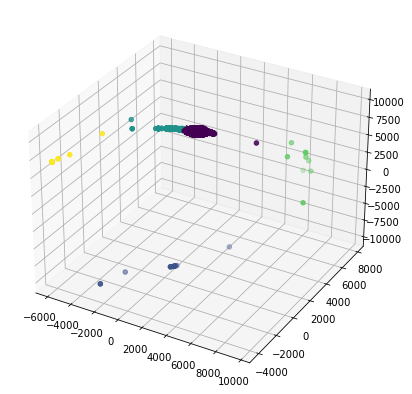

In [112]:
plt.figure(figsize=(10,7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_test_xyz['X'], X_test_xyz['Y'], X_test_xyz['Z'], c=X_test_locality_id)
plt.show()

In [113]:
# Predicting price of a house in test dataset using linear regression models trained for localities
test_price_predictions = []
for i in range(X_test.shape[0]):
    test_price_predictions.append(price_predictions[f'LOCALITY_{int(X_test_locality_id[i])}_PRICE'][i])

X_test['PRICE_PREDICTION'] = test_price_predictions
test_data_frame = pd.concat([X_test['PRICE_PREDICTION'], y_test], axis=1)
test_data_frame

,PRICE_PREDICTION,PRICE_IN_LACS
28582,106.588778,60.0
23148,77.446316,34.0
15168,106.590371,65.0
6880,193.053543,140.0
6351,119.124642,65.0
...,...,...
12368,106.556555,41.0
19598,452.893523,500.0
21924,20.097461,42.0
14258,32.610518,60.0


### R2 Score

In [114]:
print(f"R2 score [with clustering]: {r2_score(y_test, test_price_predictions)}")

R2 score [with clustering]: 0.3230656938543346


## Linear Regression without Clustering
Train a single linear regression model for all localities

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)
X_train_df = X_train.drop(['X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)
X_test_df = X_test.drop(['X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)

In [116]:
# Linear regression without clustering
linear_reg = LinearRegression()
linear_reg.fit(X_train_df, y_train)
y_pred = linear_reg.predict(X_test_df)

print(f"R2 score [without clustering]: {r2_score(y_test, y_pred)}")

R2 score [without clustering]: 0.1994509392828594
